# StatQuest: Coding Transformers from Scratch!!!
## Part 1: Decoder-Only Transformers

Copyright 2024, Joshua Starmer

---- 

In this tutorial, we will use **[PyTorch](https://pytorch.org/) + [Lightning](https://www.lightning.ai/)** to create and optimize a **Decoder-Only Transformer**, like the one shown in the picture below. Decoder-Only Transformers are taking over AI right now, and quite possibly their most famous use is in ChatGPT.

<img src="./images/dec_transformer.png" alt="a decoder-only transformer neural network" style="width: 800px;">

Although Decoder-Only Transformers look complicated and can do really cool things, the good news is that they don't actually require a lot of code. A lot of their power comes from simply making multiple copies of each component. So, with that said...

In this tutorial, you will...

- **[Code a Position Encoder Class From Scratch!!!](#position)** The position encoder gives a transformer a way to keep track of the order of the input tokens.

- **[Code an Attention Class From Scratch!!!](#attention)** The attention class allows the transformer to keep track of the relationships among words in the input and the output.

- **[Code a Decoder-Only Transformer Class From Scratch!!!](#decoder)** The Decoder-Only Transformer will combine the position encoder and attention classes that we wrote with built-in pytorch classes to process the user input and generate the output.

- **[Train the Transformer!!!](#train)** We'll train the transformer to answer simple questions.

- **[Use the Trained Transformer!!!](#use)** Finally, we'll use the transformer to answer simple questions.

#### NOTE:
This tutorial assumes that you already know the basics of coding in **Python** and are familiar with the theory behind **[Decoder-Only Transformers](https://youtu.be/bQ5BoolX9Ag)** and **[Backpropagation](https://youtu.be/IN2XmBhILt4)**. It also assumes that you are familiar with the **[Essential Matrix Algebra for Neural Networks](https://youtu.be/ZTt9gsGcdDo)** and how it applies to **[Transformers](https://youtu.be/KphmOJnLAdI)**. If not, check out the **StatQuests** by clicking on the links for each topic.

#### ALSO NOTE:
I strongly encourage you to play around with the code. Playing with the code is the best way to learn from it.

----

# Import the modules that will do all the work

The very first thing we need to do is load a bunch of Python modules. Python itself is just a basic programming language. These modules give us extra functionality to create and train a Neural Network.

**NOTE:** The code below will check and see if **Lightning** is installed, and if not, it will install it for you. However, if you also need to install PyTorch, check out there install page **[here.](https://pytorch.org/get-started/locally/)**

In [1]:
## First, check to see if lightning is installed, if not, install it.
import pip
try:
  __import__("lightning")
except ImportError:
  pip.main(['install', "lightning"])  

import torch ## torch let's us create tensors and also provides helper functions
import torch.nn as nn ## torch.nn gives us nn.Module(), nn.Embedding() and nn.Linear()
import torch.nn.functional as F # This gives us the softmax() and argmax()
from torch.optim import Adam ## We will use the Adam optimizer, which is, essentially, 
                             ## a slightly less stochastic version of stochastic gradient descent.
from torch.utils.data import TensorDataset, DataLoader ## We'll store our data in DataLoaders

import lightning as L ## Lightning makes it easier to write, optimize and scale our code

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Collecting lightning

Downloading lightning-2.4.0-py3-none-any.whl.metadata (38 kB)

Requirement already satisfied: PyYAML<8.0,>=5.4 in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from lightning) (6.0.2)

Requirement already satisfied: fsspec<2026.0,>=2022.5.0 in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from fsspec[http]<2026.0,>=2022.5.0->lightning) (2024.10.0)

Collecting lightning-utilities<2.0,>=0.10.0 (from lightning)

Downloading lightning_utilities-0.11.9-py3-none-any.whl.metadata (5.2 kB)

Requirement already satisfied: packaging<25.0,>=20.0 in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from lightning) (24.1)

Requirement already satisfied: torch<4.0,>=2.1.0 in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from lightning) (2.5.1)

Collecting torchmetrics<3.0,>=0.7.0 (from lightning)

Downloading torchmetrics-1.6.0-py3-none-any.whl.metadata (20 kB)

Requirement already satisfied: tqdm<6.0,>=4.57.0 in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from lightning) (4.66.5)

Requirement already satisfied: typing-extensions<6.0,>=4.4.0 in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from lightning) (4.12.2)

Collecting pytorch-lightning (from lightning)

Downloading pytorch_lightning-2.4.0-py3-none-any.whl.metadata (21 kB)

Requirement already satisfied: aiohttp!=4.0.0a0,!=4.0.0a1 in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from fsspec[http]<2026.0,>=2022.5.0->lightning) (3.10.9)

Requirement already satisfied: setuptools in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from lightning-utilities<2.0,>=0.10.0->lightning) (75.1.0)

Requirement already satisfied: filelock in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from torch<4.0,>=2.1.0->lightning) (3.16.1)

Requirement already satisfied: networkx in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from torch<4.0,>=2.1.0->lightning) (3.4.2)

Requirement already satisfied: jinja2 in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from torch<4.0,>=2.1.0->lightning) (3.1.4)

Requirement already satisfied: sympy==1.13.1 in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from torch<4.0,>=2.1.0->lightning) (1.13.1)

Requirement already satisfied: mpmath<1.4,>=1.1.0 in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from sympy==1.13.1->torch<4.0,>=2.1.0->lightning) (1.3.0)

Requirement already satisfied: numpy>1.20.0 in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from torchmetrics<3.0,>=0.7.0->lightning) (2.0.2)

Requirement already satisfied: colorama in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from tqdm<6.0,>=4.57.0->lightning) (0.4.6)

Requirement already satisfied: aiohappyeyeballs>=2.3.0 in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from aiohttp!=4.0.0a0,!=4.0.0a1->fsspec[http]<2026.0,>=2022.5.0->lightning) (2.4.3)

Requirement already satisfied: aiosignal>=1.1.2 in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from aiohttp!=4.0.0a0,!=4.0.0a1->fsspec[http]<2026.0,>=2022.5.0->lightning) (1.3.1)

Requirement already satisfied: attrs>=17.3.0 in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from aiohttp!=4.0.0a0,!=4.0.0a1->fsspec[http]<2026.0,>=2022.5.0->lightning) (24.2.0)

Requirement already satisfied: frozenlist>=1.1.1 in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from aiohttp!=4.0.0a0,!=4.0.0a1->fsspec[http]<2026.0,>=2022.5.0->lightning) (1.4.1)

Requirement already satisfied: multidict<7.0,>=4.5 in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from aiohttp!=4.0.0a0,!=4.0.0a1->fsspec[http]<2026.0,>=2022.5.0->lightning) (6.1.0)

Requirement already satisfied: yarl<2.0,>=1.12.0 in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from aiohttp!=4.0.0a0,!=4.0.0a1->fsspec[http]<2026.0,>=2022.5.0->lightning) (1.13.1)

Requirement already satisfied: MarkupSafe>=2.0 in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from jinja2->torch<4.0,>=2.1.0->lightning) (2.1.5)

Requirement already satisfied: idna>=2.0 in c:\users\vmunagal\appdata\local\programs\python\python312\lib\site-packages (from yarl<2.0,>=1.12.0->aiohttp!=4.0.0a0,!=4.0.0a1->fsspec[http]<2026.0,>=2022.5.0->lightning) (3.10)

Downloading lightning-2.4.0-py3-none-any.whl (810 kB)

c:\Users\vmunagal\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_vendor\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Downloading lightning_utilities-0.11.9-py3-none-any.whl (28 kB)

Downloading torchmetrics-1.6.0-py3-none-any.whl (926 kB)

Downloading pytorch_lightning-2.4.0-py3-none-any.whl (815 kB)

Installing collected packages: lightning-utilities, torchmetrics, pytorch-lightning, lightning

Successfully installed lightning-2.4.0 lightning-utilities-0.11.9 pytorch-lightning-2.4.0 torchmetrics-1.6.0

c:\Users\vmunagal\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


----

# Create the input and output and data

In this tutorial we will build a simple Decoder-Only Transformer that can answer two super simple questions, **What is StatQuest?** and **StatQuest is what?**, and give them both the same answer, **Awesome!!!**

In order to keep track of our simple dataset,
we'll create a dictionary that maps the words and tokens to ID numbers. This is because the class we will use to do word embedding for us, `nn.Embedding()`, only accepts ID numbers as input, rather than words or tokens. Then we will use the dictionary to create a **Dataloader** that contains the questions and the desired answers encoded as ID numbers. Ultimately we'll use the **Dataloader** to train the transformer. **NOTE:** Dataloaders are designed to scale to very large datasets, so this simple example should be useful even when you have a terabyte of text.

**ALSO NOTE:** The **inputs** and **labels** for the training data used with a Decoder-Only Transformer can seem a little strange at first. This is because a Decoder-Only Transformer generates a lot of the user input in addition to the response. To get a sense of what this means, let's pretend we want to train our Decoder-Only Transformer to answer the question **What is StatQuest?** with the response **Awesome**. In the figure below, on the left side, we see that the first token in the input **What** generates the output **is**. During training, we can compare this output to the known second token in the input, and if it is different, use that difference to modify the weights and biases in the model. Thus, even though **is** is part of the **input**, it is also part of the **label** that we use to evaluate how well the Decoder-Only Transformer is performing and whether or not the weights and biases should be changed. Likewise, **StatQuest**, **<\EOS>**, and **awesome** can also be in both the **input** and in the **label** because we know we want the Decoder-Only Transformer to use them as inputs and generate them as outputs.

<img src="./images/expected_input_output_1.png" alt="The expected input and outputs during training" style="width: 800px;">

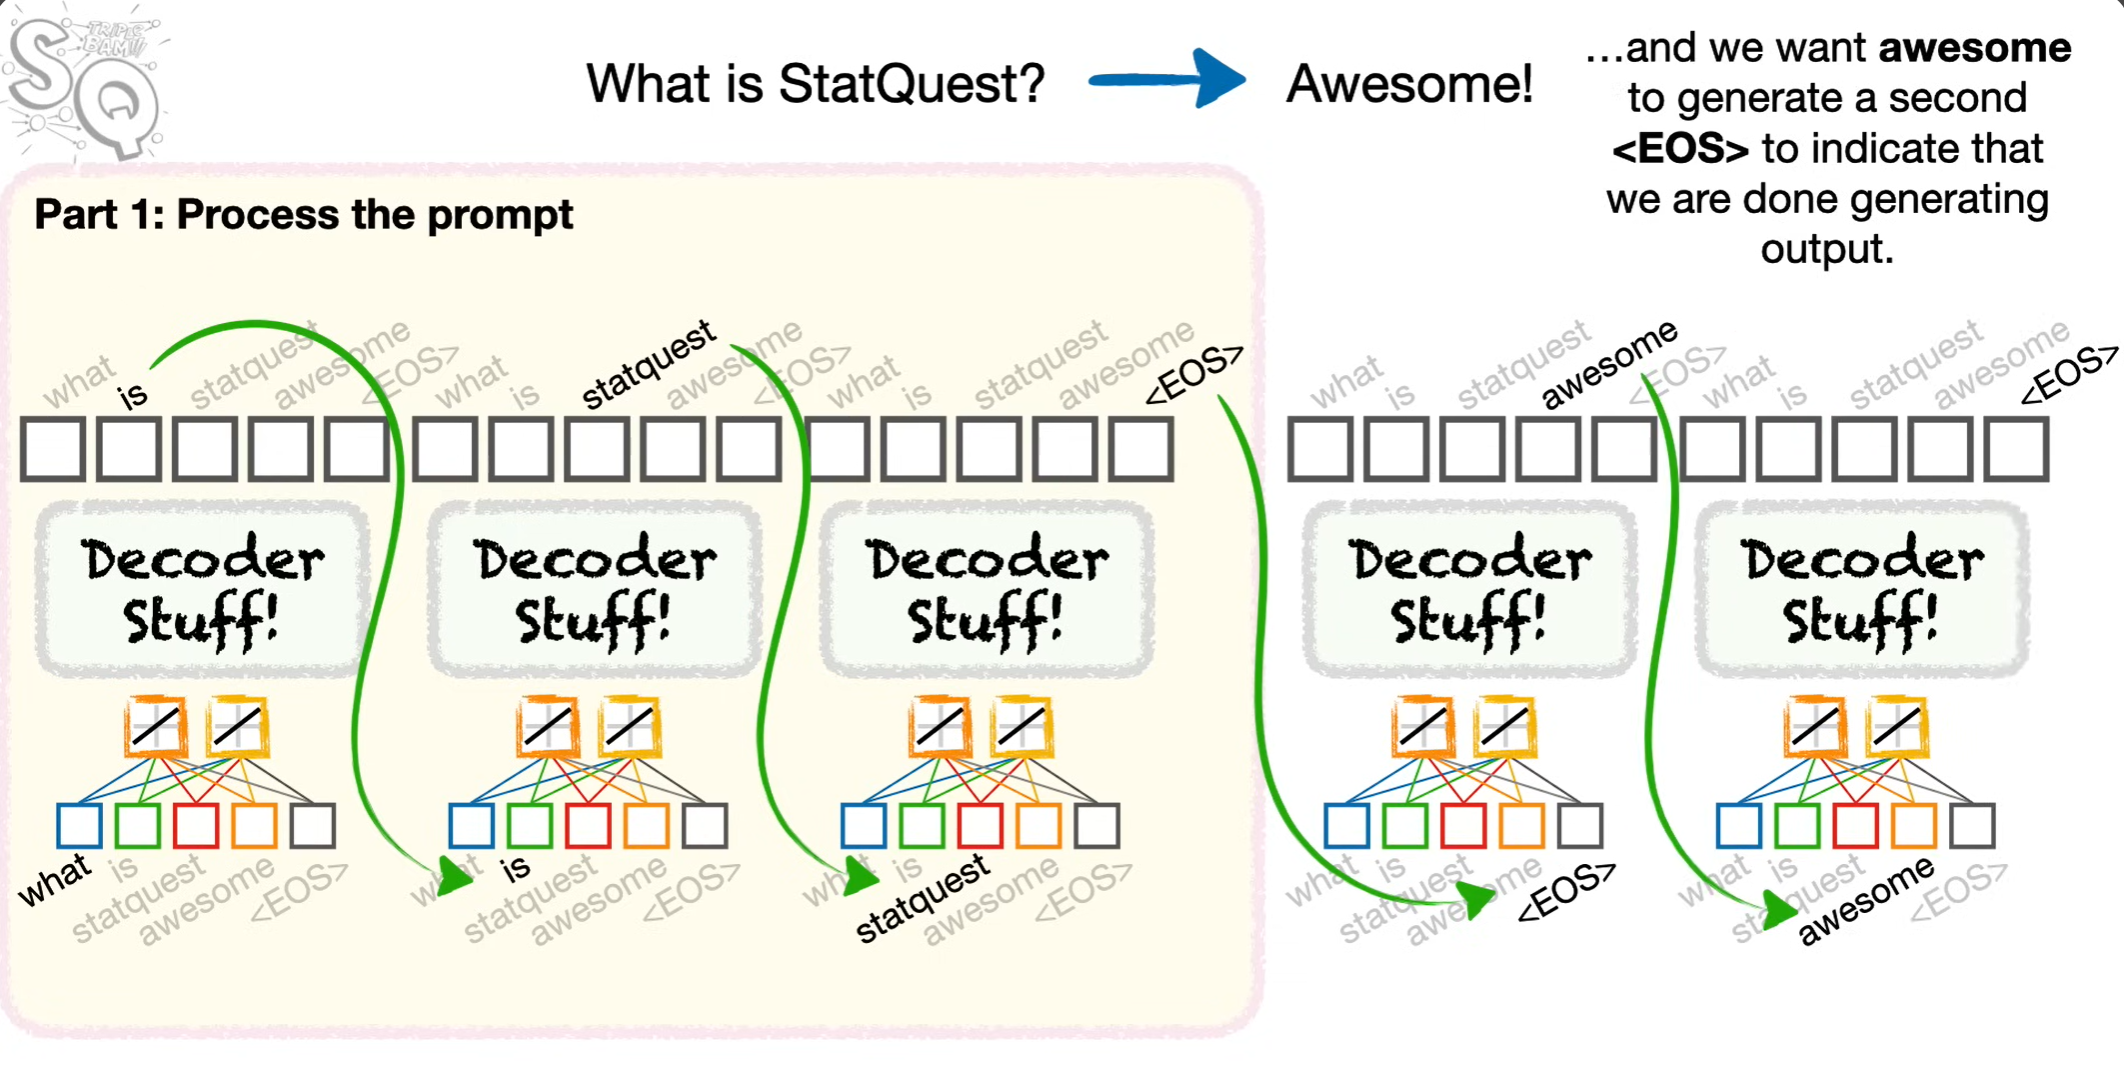

In [2]:
## first, we create a dictionary that maps vocabulary tokens to id numbers...
token_to_id = {'what' : 0,
               'is' : 1,
               'statquest' : 2,
               'awesome': 3,
               '<EOS>' : 4, ## <EOS> = end of sequence
              }
## ...then we create a dictionary that maps the ids to tokens. This will help us interpret the output.
## We use the "map()" function to apply the "reversed()" function to each tuple (i.e. ('what', 0)) stored
## in the token_to_id dictionary. We then use dict() to make a new dictionary from the
## reversed tuples.
id_to_token = dict(map(reversed, token_to_id.items()))

## NOTE: Because we are using a Decoder-Only Transformer, the inputs contain
##       the questions ("what is statquest?" and "statquest is what?") followed
##       by an <EOS> token followed by the response, "awesome".
##       This is because all of those tokens will be used as inputs to the Decoder-Only
##       Transformer during Training. (See the illustration above for more details) 
## ALSO NOTE: When we train this way, it's called "teacher forcing".
##       Teacher forcing helps us train the neural network faster.
inputs = torch.tensor([[token_to_id["what"], ## input #1: what is statquest <EOS> awesome
                        token_to_id["is"], 
                        token_to_id["statquest"], 
                        token_to_id["<EOS>"],
                        token_to_id["awesome"]], 
                       
                       [token_to_id["statquest"], # input #2: statquest is what <EOS> awesome
                        token_to_id["is"], 
                        token_to_id["what"], 
                        token_to_id["<EOS>"], 
                        token_to_id["awesome"]]])

## NOTE: Because we are using a Decoder-Only Transformer the outputs, or
##       the predictions, are the input questions (minus the first word) followed by 
##       <EOS> awesome <EOS>.  The first <EOS> means we're done processing the input question
##       and the second <EOS> means we are done generating the output.
##       See the illustration above for more details.
labels = torch.tensor([[token_to_id["is"], 
                        token_to_id["statquest"], 
                        token_to_id["<EOS>"], 
                        token_to_id["awesome"], 
                        token_to_id["<EOS>"]],  
                       
                       [token_to_id["is"], 
                        token_to_id["what"], 
                        token_to_id["<EOS>"], 
                        token_to_id["awesome"], 
                        token_to_id["<EOS>"]]])

## Now let's package everything up into a DataLoader...
dataset = TensorDataset(inputs, labels) 
dataloader = DataLoader(dataset)

In [12]:
#dataset.tensors
dataloader.dataset.tensors

(tensor([[0, 1, 2, 4, 3],
         [2, 1, 0, 4, 3]]),
 tensor([[1, 2, 4, 3, 4],
         [1, 0, 4, 3, 4]]))

Now that we have created the input and output datasets and the **Dataloader** to train the model, let's start building it.

----

<a id="position"></a>
# Position Encoding

Position Encoding helps the transformer keep track of the order of the words in the input and the output. For example, in the picture below, we see that the two phrases **Squatch eats pizza** and **Pizza eats Squatch** both have the exact same words, but, due to differences in the word order, have very different meanings. Thus, keeping track of word order is very important.

<img src="./images/squatch_eats_pizza.png" alt="Squatch eats pizza is very different from Pizza eats Squatch" style="width: 800px;">

There are a bunch of ways for a transformer to keep track of word order, but one popular method is to use a series of alternating sine and cosine curves (seen below). The number of sine and cosine curves depends on how many numbers, or word embedding values, we use to represent each token. In the context of Transformers, the number of numbers, or word embedding values, we use to represent each token is the **dimension** of the transformer. So, if the transformer's dimension is 2, meaning that it uses 2 numbers to represent each token, then we only need one sine and one cosine to generate two position encoding values. 

<img src="./images/pos_encoding_1.png" alt="Sine and cosine squiggles for position encoding" style="width: 800px;">

In contrast, as we see in the illustration below, if the transformer's dimension is 4, then we'll need 2 sine curves alternating with 2 cosine curves, for a total of 4 curves.

<img src="./images/pos_encoding_2.png" alt="More sine and cosine squiggles for position encoding" style="width: 800px;">

As we see in the illustration above, the additional pair of sine and cosine curves have a wider period (they repeat less frequently) than the first pair. Increasing the period for each additional pair of curves ensures that each position is represented by a unique combination of values.

**NOTE:** The reason why we are bothering to create a class to do positional encoding, instead of just adding this code directly to the transformer, is that we can easily re-use it in an Encoder-Only Transformer or an Encoder-Decoder Transformer. So, by creating a class that does positional encoding, we can code it once, and then just create instances when and where we need it.

**ALSO NOTE:** Since the position encoding values never change, meaning that the first token always uses the same position encoding values regardless of what that token is, we precompute them and save them in a lookup table. This makes adding position encoding values super fast.

Now that we understand the ideas that we want to implement in the Position Encoding class, let's code it!

In [13]:
class PositionEncoding(nn.Module):
    
    def __init__(self, d_model=2, max_len=6):
        ## d_model = The dimension of the transformer, which is also the number of embedding values per token.
        ##           In the transformer I used in the StatQuest: Transformer Neural Networks Clearly Explained!!!
        ##           d_model=2, so that's what we'll use as a default for now.
        ##           However, in "Attention Is All You Need" d_model=512
        ## max_len = maximum number of tokens we allow as input.
        ##           Since we are precomputing the position encoding values and storing them in a lookup table
        ##           we can use d_model and max_len to determine the number of rows and columns in that
        ##           lookup table.
        ##
        ##           In this simple example, we are only using short phrases, so we are using
        ##           max_len=6 as the default setting.
        ##           However, in The Annotated Transformer, they set the default value for max_len to 5000
        
        super().__init__()
        ## We call the super's init because by creating our own __init__() method, we overwrite the one
        ## we inherited from nn.Module. So we have to explicity call nn.Module's __init__(), otherwise it
        ## won't get initialized. NOTE: If we didn't write our own __init__(), then we would not have
        ## to call super().__init__(). Alternatively, if we didn't want to access any of nn.Module's methods, 
        ## we wouldn't have to call it then either.

        ## Now we create a lookup table, pe, of position encoding values and initialize all of them to 0.
        ## To do this, we will make a matrix of 0s that has max_len rows and d_model columns.
        ## for example...
        ## torch.zeros(3, 2)
        ## ...returns a matrix of 0s with 3 rows and 2 columns...
        ## tensor([[0., 0.],
        ##         [0., 0.],
        ##         [0., 0.]])
        pe = torch.zeros(max_len, d_model)

        ## Now we create a sequence of numbers for each position that a token can have in the input (or output).
        ## For example, if the input tokens where "I'm happy today!", then "I'm" would get the first
        ## position, 0, "happy" would get the second position, 1, and "today!" would get the third position, 2.
        ## NOTE: Since we are going to be doing math with these position indices to create the 
        ## positional encoding for each one, we need them to be floats rather than ints.
        ## 
        ## NOTE: Two ways to create floats are...
        ##
        ## torch.arange(start=0, end=3, step=1, dtype=torch.float)
        ##
        ## ...and...
        ##
        ## torch.arange(start=0, end=3, step=1).float()
        ##
        ## ...but the latter is just as clear and requires less typing.
        ##
        ## Lastly, .unsqueeze(1) converts the single list of numbers that torch.arange creates into a matrix with
        ## one row for each index, and all of the indices in a single column. So if "max_len" = 3, then we
        ## would create a matrix with 3 rows and 1 column like this...
        ##
        ## torch.arange(start=0, end=3, step=1, dtype=torch.float).unsqueeze(1)
        ##
        ## ...returns...
        ##
        ## tensor([[0.],
        ##         [1.],
        ##         [2.]])        
        position = torch.arange(start=0, end=max_len, step=1).float().unsqueeze(1)


        ## Here is where we start doing the math to determine the y-axis coordinates on the
        ## sine and cosine curves.
        ##
        ## The positional encoding equations used in "Attention is all you need" are...
        ##
        ## PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
        ## PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
        ##
        ## ...and we see, within the sin() and cos() functions, we divide "pos" by some number that depends
        ## on the index (i) and total number of PE values we want per token (d_model). 
        ##
        ## NOTE: When the index, i, is 0 then we are calculating the y-axis coordinates on the **first pair** 
        ##       of sine and cosine curves. When i=1, then we are calculating the y-axis coordiantes on the 
        ##       **second pair** of sine and cosine curves. etc. etc.
        ##
        ## Now, pretty much everyone calculates the term we use to divide "pos" by first, and they do it with
        ## code that looks like this...
        ##
        ## div_term = torch.exp(torch.arange(start=0, end=d_model, step=2).float() * -(math.log(10000.0) / d_model))
        ##
        ## Now, at least to me, it's not obvious that div_term = 1/(10000^(2i/d_model)) for a few reasons:
        ##
        ##    1) div_term wraps everything in a call to torch.exp() 
        ##    2) It uses log()
        ##    2) The order of the terms is different 
        ##
        ## The reason for these differences is, presumably, trying to prevent underflow (getting too close to 0).
        ## So, to show that div_term = 1/(10000^(2i/d_model))...
        ##
        ## 1) Swap out math.log() for torch.log() (doing this requires converting 10000.0 to a tensor, which is my
        ##    guess for why they used math.log() instead of torch.log())...
        ##
        ## torch.exp(torch.arange(start=0, end=d_model, step=2).float() * -(torch.log(torch.tensor(10000.0)) / d_model))
        ##
        ## 2) Rearrange the terms...
        ##
        ## torch.exp(-1 * (torch.log(torch.tensor(10000.0)) * torch.arange(start=0, end=d_model, step=2).float() / d_model))
        ##
        ## 3) Pull out the -1 with exp(-1 * x) = 1/exp(x)
        ##
        ## 1/torch.exp(torch.log(torch.tensor(10000.0)) * torch.arange(start=0, end=d_model, step=2).float() / d_model)
        ##
        ## 4) Use exp(a * b) = exp(a)^b to pull out the 2i/d_model term...
        ##
        ## 1/torch.exp(torch.log(torch.tensor(10000.0)))^(torch.arange(start=0, end=d_model, step=2).float() / d_model)
        ##
        ## 5) Use exp(log(x)) = x to get the original form of the denominator...
        ##
        ## 1/(torch.tensor(10000.0)^(torch.arange(start=0, end=d_model, step=2).float() / d_model))
        ##
        ## 6) Bam.
        ## 
        ## So, that being said, I don't think underflow is actually that big an issue. In fact, some coder at Hugging Face
        ## also doesn't think so, and their code for positional encoding in DistilBERT (a streamlined version of BERT, which
        ## is a transformer model)
        ## calculates the values directly - using the form of the equation found in original Attention is all you need
        ## manuscript. See...
        ## https://github.com/huggingface/transformers/blob/455c6390938a5c737fa63e78396cedae41e4e87e/src/transformers/modeling_distilbert.py#L53
        ## So I think we can simplify the code, but I'm also writing all these comments to show that it is equivalent to what
        ## you'll see in the wild...
        ##
        ## Now let's create an index for the embedding positions to simplify the code a little more...
        embedding_index = torch.arange(start=0, end=d_model, step=2).float()
        ## NOTE: Setting step=2 results in the same sequence numbers that we would get if we multiplied i by 2.
        ##       So we can save ourselves a little math by just setting step=2.

        ## And now, finally, let's create div_term...
        div_term = 1/torch.tensor(10000.0)**(embedding_index / d_model)
        
        ## Now we calculate the actual positional encoding values. Remember 'pe' was initialized as a matrix of 0s
        ## with max_len (max number of input tokens) rows and d_model (number of embedding values per token) columns.
        pe[:, 0::2] = torch.sin(position * div_term) ## every other column, starting with the 1st, has sin() values
        pe[:, 1::2] = torch.cos(position * div_term) ## every other column, starting with the 2nd, has cos() values
        ## NOTE: If the notation for indexing 'pe[]' looks cryptic to you, read on...
        ##
        ## First, let's look at the general indexing notation:
        ##
        ## For each row or column in matrix we can select elements in that
        ## row or column with the following indexs...
        ##
        ## i:j:k = select elements between i and j with stepsize = k.
        ##
        ## ...where...
        ##
        ## i defaults to 0
        ## j defaults to the number of elements in the row, column or whatever.
        ## k defaults to 1
        ##
        ## Now that we have looked at the general notation, let's look at specific
        ## examples so that we can understand it.
        ##
        ## We'll start with: pe[:, 0::2]
        ##
        ## The stuff that comes before the comma (in this case ':') refers to the rows we want to select.
        ## The ':' before the comma means "select all rows" because we are not providing specific 
        ## values for i, j and k and, instead, just using the default values.
        ##
        ## The stuff after the comma refers to the columns we want to select.
        ## In this case, we have '0::2', and that means we start with
        ## the first column (column =  0) and go to the end (using the default value for j)
        ## and we set the stepsize to 2, which means we skip every other column.
        ##
        ## Now to understand pe[:, 1::2]
        ##
        ## Again, the stuff before the comma refers to the rows, and, just like before
        ## we use default values for i,j and k, so we select all rows.
        ##
        ## The stuff that comes after the comma refers to the columns.
        ## In this case, we start with the 2nd column (column = 1), and go to the end
        ## (using the default value for 'j') and we set the stepsize to 2, which
        ## means we skip every other column.
        ##
        ## NOTE: using this ':' based notation is called "indexing" and also called "slicing"
        
        ## Now we "register 'pe'.
        self.register_buffer('pe', pe) ## "register_buffer()" ensures that
                                       ## 'pe' will be moved to wherever the model gets
                                       ## moved to. So if the model is moved to a GPU, then,
                                       ## even though we don't need to optimize 'pe', it will 
                                       ## also be moved to that GPU. This, in turn, means
                                       ## that accessing 'pe' will be relatively fast copared
                                       ## to having a GPU have to get the data from a CPU.

    ## Because this class, PositionEncoding, inherits from nn.Module, the forward() method 
    ## is called by default when we use a PositionEncoding() object.
    ## In other words, after we create a PositionEncoding() object, pe = PositionEncoding(),
    ## then pe(word_embeddings) will call forward() and so this is where 
    ## we will add the position encoding values to the word embedding values
    def forward(self, word_embeddings):
    
        return word_embeddings + self.pe[:word_embeddings.size(0), :] ## word_embeddings.size(0) = number of embeddings
                                                                      ## NOTE: That second ':' is optional and 
                                                                      ## we could re-write it like this: 
                                                                      ## self.pe[:word_embeddings.size(0)]

----

<a id="attention"></a>
# Attention
We're going to code an `Attention` class to do all of the types of attention that a transformer might need: **Self-Attention**, **Masked Self-Attention** (which is used by the Decoder during training), and **Encoder-Decoder Attention**.

**Self-Attention** is a type of attention used in Encoder-Decoder and Encoder-Only transformers. It allows every word in a phrase to define a relationship with any other word in the phrase, regardless of the order of the words. In other words, if the phrase is **The pizza came out of the oven and it tasted good!**, then the word **it** can define it's relationship with every word in that phrase, including words that came after it, like **tasted** and **good**, as illustrated by the blue arrows in the figure below.

<img src="./images/self_attention_1.png" alt="An illustration of self-attention" style="width: 800px;">

**Masked Self-Attention** is used by Encoder-Decoder and Decoder-Only transformers and it allows each word in a phrase to define a relationship with itself and the words that came before it. In other words, **Masked Self-Attention** prevents the transformer from "looking ahead". This is illustrated below where the word **it** can define relationships with itself and everything that came earlier in the input. In Encoder-Decoder transformers, **Masked Self-Attention** is used during training, when we know what the output should be, but we still force the decoder to generate it one token at a time, thus, limiting attention to only output words that came earlier. In contrast, Decoder-Only transformers use **Masked Self-Attention** all the time, on the input and the output, during training and inference. Thus, even though the Decoder-Only transformer can see all of the input during training and inference, it still only allows the attention values for each word to depend on words that came before it.

<img src="./images/masked_attention_1.png" alt="An illustration of Masked Self-Attention" style="width: 800px;">

**Encoder-Decoder Attention** is only used in Encoder-Decoder transformers, where there is a distinct separation of the part of the transformer that processes the input (the encoder) from the part that generates the output (the decoder). **Encoder-Decoder Attention** lets each word in the output (in the decoder) define relationships with all the words in the input (in the encoder), as illustrated in the figure below.

<img src="./images/enc_dec_attention_1.png" alt="An illustration of Encoder-Decoder Attention" style="width: 800px;">

Now that we have a general sense of the three types of attention used in transformers, we can talk about how it's calculated. 

First, the general equations for the different types of attention are almost identical as seen in the figure below. In the equations, **Q** is for the **Query** matrix, **K** is for the **Key** matrix and **V** is for the **Value** matrix. On the left, we have the equation for Self-Attention and Encoder-Decoder Attention. The differences in these types of attention are not from the equation we use, but from how the **Q**, **K**, and **V** matrices are computed. On the right, we see the equation for Masked Self-Attention and the only difference it has from the equation on the left is the addition of a **Mask** matrix, **M**, that prevents words that come after a specific **Query** from being included in the final attention scores. 

<img src="./images/attention_equations.png" alt="Equations for computing attention" style="width: 800px;">

**NOTE:** Since both equations are very similar, we'll go through one example and point out the key differences when we get to them.

First, given word embedding values for each word/token in the input phrase **\<SOS> let's go** in matrix form, we multiply them by matrices of weights to create **Queries**, **Keys**, and **Values** 

<img src="./images/attention_compute_q.png" alt="Computing the Q matrix" style="width: 800px;">

<img src="./images/attention_compute_k.png" alt="Computing the K matrix" style="width: 800px;">

<img src="./images/attention_compute_v.png" alt="Computing the V matrix" style="width: 800px;">

We then multiply the **Queries** by the transpose of the **Keys** so that the query for each word calculates a similarity value with the keys for all of the words. **NOTE:** As seen in the illustration below, Masked Self-Attention calculates the values for all **Query/Key** pairs, but, ultimately, ignores values for when a token's **Query** comes before other token's **Keys**. For example, if the **Query** is for the first token **\<SOS>**, then Masked Self-Attention will ignore the values calculated with **Keys** for **Let's** and **go** because those tokens come after **\<SOS>**.

<img src="./images/attention_q_times_kt.png" alt="Calculating the similarities between Queries and Keys" style="width: 800px;">

The next step is to scale the similarity scores by the square root of the number of columns in the **Key** matrix, which represents the number of values used to represent each token. In this case, we scale by the square root of 2.

<img src="./images/attention_scaling_scores.png" alt="Scaling the similarities" style="width: 800px;">

Now, if we were doing Masked Self-Attention, we would mask out the values we want to ignore by adding -infinity to them, as seen below. This step is the only difference between Self-Attention and Masked Self-Attention. 

<img src="./images/attention_masking.png" alt="Masking out scaled similarities for Masked Self-Attention" style="width: 800px;">

The next step is to apply the **SoftMax()** function to each row in the scaled similarities. We'll do this first for the Self-Attention without a mask (below)...

<img src="./images/attention_softmax.png" alt="Applying the SoftMax() function to each row in the scaled similarity matrix" style="width: 800px;">

...and we'll also do it for Masked Self-Attention (below).

<img src="./images/attention_softmax_masked.png" alt="Applying the SoftMax() function to each row in the masked scaled similarity matrix" style="width: 800px;">

The `SoftMax()` function gives us percentages that the **Values** for each token should contribute to the attention score for a specific token. Thus, we can get the final attention scores by multiplying the percentages with the **Values** in matrix **V**. First, we'll do this with the unmasked percentages...

<img src="./images/attention_final_scores.png" alt="Calculating the final attention scores" style="width: 800px;">

...and then we'll calculate the final Masked Self-Attention scores.

<img src="./images/attention_final_scores_masked.png" alt="Calculating the final attention scores" style="width: 800px;">

# BAM!

Now that we know how to calculate the different types of attention, let's code the `Attention()` class.

In [ ]:
class Attention(nn.Module): 
    
    def __init__(self, d_model=2):
        ## d_model = the number of embedding values per token.
        ##           In the transformer I used in the StatQuest: Transformer Neural Networks Clearly Explained!!!
        ##           d_model=2, so that's what we'll use as a default for now.
        ##           However, in "Attention Is All You Need" d_model=512

        
        super().__init__()
        
        self.d_model=d_model
        
        ## Initialize the Weights (W) that we'll use to create the
        ## query (q), key (k) and value (v) numbers for each token
        ## NOTE: Most implementations that I looked at include the bias terms
        ##       but I didn't use them in my video (since they are not in the 
        ##       original Attention is All You Need paper).
        self.W_q = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.W_k = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.W_v = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        
        ## NOTE: In this simple example, we are not training on the data in "batches"
        ##       However, by defining variables for row_dim and col_dim, we could
        ##       allow for batches by setting row_dim to 1 and col_com to 2.
        self.row_dim = 0
        self.col_dim = 1

        
    def forward(self, encodings_for_q, encodings_for_k, encodings_for_v, mask=None):
        ## Create the query, key and values using the encodings
        ## associated with each token (token encodings)
        ##
        ## NOTE: For Encoder-Decoder Attention, the encodings for q come from
        ##       the decoder and the encodings for k and v come from the output
        ##       from the encoder.
        ##       In all of the other types of attention, the encodings all
        ##       come from the same source.
        q = self.W_q(encodings_for_q)
        k = self.W_k(encodings_for_k)
        v = self.W_v(encodings_for_v)

        ## Compute attention scores
        ## the equation is (q * k^T)/sqrt(d_model)
        ## NOTE: It seems most people use "reverse indexing" for the dimensions when transposing k
        ##       k.transpose(dim0, dim1) will transpose k by swapping dim0 and dim1
        ##       In standard matrix notation, we would want to swap rows (dim=0) with columns (dim=1)
        ##       If we have 3 dimensions, because of batching, and the batch was the first dimension
        ##       And thus dims are defined batch = 0, rows = 1, columns = 2
        ##       then dim0=-2 = 3 - 2 = 1. dim1=-1 = 3 - 1 = 2.
        ##       Alternatively, we could put the batches in dim 3, and thus, dim 0 would still be rows
        ##       and dim 1 would still be columns. I'm not sure why batches are put in dim 0...
        ##
        ##       Likewise, the q.size(-1) uses negative indexing to rever to the number of columns in the query
        ##       which tells us d_model. Alternatively, we could ust q.size(2) if we have batches in the first
        ##       dimension or q.size(1) if we have batches in the 3rd dimension.
        ##
        ##       Since there are a bunch of ways to index things, I think the best thing to do is use
        ##       variables "row_dim" and "col_dim" instead of numbers...
        sims = torch.matmul(q, k.transpose(dim0=self.row_dim, dim1=self.col_dim))

        scaled_sims = sims / torch.tensor(k.size(self.col_dim)**0.5)

        if mask is not None:
            ## Here we are masking out things we don't want to pay attention to,
            ## like tokens that come after the current token.
            ## We can also use masking to block out the <PAD> token,
            ## which is used when we have a batch of inputs sequences
            ## and they are not all the exact same length. Because the batch is passed
            ## in as a matrix, each input sequence has to have the same length, so we
            ## add <PAD> to the shorter sequences so that they are all as long ast the
            ## longest sequence.
            ##
            ## We replace <PAD>, or tokens that come after the current token
            ## with a very large negative number so that the SoftMax() function
            ## will give all masked elements an output value (or "probability") of 0.
            scaled_sims = scaled_sims.masked_fill(mask=mask, value=-1e9) # I've also seen -1e20 and -9e15 used in masking
        
        ## Apply softmax to determine what percent of each token's value to
        ## use in the final attention values.
        attention_percents = F.softmax(scaled_sims, dim=self.col_dim)

        ## Scale the values by their associated percentages and add them up.
        attention_scores = torch.matmul(attention_percents, v)
        
        return attention_scores

# BAM!

Now that we have coded the `Attention()` class, we can build a Decoder-Only Transformer.

----

<a id="decoder"></a>
# The Decoder-Only Transformer



<img src="./images/dec_transformer.png" alt="A diagram of an decoder" style="width: 800px;">

A Decoder-Only Transformer simply brings together...

- Word Embedding
- Position Encoding
- Masked Self-Attention
- Residual Connections
- A fully connected layer
- SoftMax - However, the loss function we are using `nn.CrossEntropyLoss()`, applies the SoftMax for us.

In [ ]:
class DecoderOnlyTransformer(L.LightningModule):
    
    def __init__(self, num_tokens=4, d_model=2, max_len=6):
        
        super().__init__()
        
        ## We are set the seed so that you can get the same results as me.
        L.seed_everything(seed=42)
        
        
        ## NOTE: In this simple example, we are just using a "single layer" decoder.
        ##       If we wanted to have multiple layers of decoder, then we would
        ##       take the output of one decoder module and use it as input to
        ##       the next module.
        
        self.we = nn.Embedding(num_embeddings=num_tokens, 
                               embedding_dim=d_model)     
        
        self.pe = PositionEncoding(d_model=d_model, 
                                   max_len=max_len)

        self.self_attention = Attention(d_model=d_model)
        ## NOTE: In this simple example, we are not doing multi-head attention
        ## If we wanted to do multi-head attention, we could
        ## initailize more Attention objects like this...
        ##
        ## self.self_attention_2 = Attention(d_model=d_model)
        ## self.self_attention_3 = Attention(d_model=d_model)
        ##
        ## If d_model=2, then using 3 self_attention objects would 
        ## result in d_model*3 = 6 self-attention values per token, 
        ## so we would need to initialize
        ## a fully connected layer to reduce the dimension of the 
        ## self attention values back down to d_model like this:
        ## 
        ## self.reduce_attention_dim = nn.Linear(in_features=(num_attention_heads*d_model), out_features=d_model)

        self.fc_layer = nn.Linear(in_features=d_model, out_features=num_tokens)
        
        self.loss = nn.CrossEntropyLoss()
        
        
    def forward(self, token_ids):
                
        word_embeddings = self.we(token_ids)        
        position_encoded = self.pe(word_embeddings)
        
        ## For the decoder-only transformer, we need to use "masked self-attention" so that 
        ## when we are training we can't cheat and look ahead at
        ## what words come after the current word.
        ## To create the mask we are creating a matrix where the lower triangle
        ## is filled with 0, and everything above the diagonal is filled with 0s.
        mask = torch.tril(torch.ones((token_ids.size(dim=0), token_ids.size(dim=0)), device=self.device))
        ## NOTE: The device=self.device is needed because we are creating a new
        ##       tensor, mask, in the forward() method, which, by default, goes
        ##       to the CPU. If all we have is a CPU, then we don't need it, but
        ##       if we want to train on a GPU, we need to make sure mask goes
        ##       there too. Using self.device allows us tyo not worry about whether
        ##       or not we are using a GPU or CPU or whatever, it will make sure
        ##       mask is where it needs to go.

        ## We then replace the 0s above the digaonal, which represent the words
        ## we want to be masked out, with "True", and replace the 1s in the lower
        ## triangle, which represent the words we want to include when we calcualte
        ## self-attention for a specific word in the output, with "False".
        mask = mask == 0
        
        self_attention_values = self.self_attention(position_encoded, 
                                                    position_encoded, 
                                                    position_encoded, 
                                                    mask=mask)
        ## NOTE: If we were doing multi-head attention, we would
        ## calculate the self-attention values with the other attention objects
        ## like this...
        ##
        ## self_attention_values_2 = self.self_attention_2(...)
        ## self_attention_values 3 = self.self_attention_3(...)
        ## 
        ## ...then we would concatenate all the self attention values...
        ##
        ## all_self_attention_values = torch.cat(self_attention_values_1, ...)
        ##
        ## ...and then run them through reduce_dim to get back to d_model values per token
        ##
        ## final_self_attention_values = self.reduce_attention_dim(all_self_attention_values)
                
        residual_connection_values = position_encoded + self_attention_values
        
        fc_layer_output = self.fc_layer(residual_connection_values)
        
        return fc_layer_output
    
    
    def configure_optimizers(self): 
        ## configure_optimizers() simply passes the parameters we want to
        ## optimize to the optimzes and sets the learning rate
        return Adam(self.parameters(), lr=0.1)
    
    
    def training_step(self, batch, batch_idx): 
        ## training_step() is called by Lightning trainer when 
        ## we want to train the model.
        input_tokens, labels = batch # collect input
        output = self.forward(input_tokens[0])
        loss = self.loss(output, labels[0])
                    
        return loss

# BAM!

Now that we have coded up the `DecoderOnlyTransformer()` class, let's see if it works correctly without training. You never know, it might just work! 

To use the transformer, we run an input phrase, either **what is statquest \<EOS>** or **statquest is what \<EOS>**, through the transformer to get the next predicted token. If the next predicted token is not **\<EOS>**, then we add the predicted token to the input tokens and run that through the transformer and repeat until we get the **\<EOS>** token or reach the maximum sequence length.

In [ ]:
## First, create a model from DecoderOnlyTransformer()
model = DecoderOnlyTransformer(num_tokens=len(token_to_id), d_model=2, max_len=6)

## Now create the input for the transformer...
model_input = torch.tensor([token_to_id["what"], 
                            token_to_id["is"], 
                            token_to_id["statquest"], 
                            token_to_id["<EOS>"]])
input_length = model_input.size(dim=0)

## Now get get predictions from the model
predictions = model(model_input) 
## NOTE: "predictions" is the output from the fully connected layer,
##      not a softmax() function. We could, if we wanted to,
##      Run "predictions" through a softmax() function, but 
##      since we're going to select the item with the largest value
##      we can just use argmax instead...
## ALSO NOTE: "predictions" is a matrix, with one row of predicted values
##      per input token. Since we only want the prediction from the
##      last row (the most recent prediction) we use reverse index for the
##      row, -1.
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
## We'll store predicted_id in an array, predicted_ids, that
## we'll add to each time we predict a new output token.
predicted_ids = predicted_id

## Now use a loop to predict output tokens until we get an 
## <EOS> token.
max_length = 6
for i in range(input_length, max_length):
    if (predicted_id == token_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
        break
    
    model_input = torch.cat((model_input, predicted_id))
    
    predictions = model(model_input) 
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))
        
## Now printout the predicted output phrase.
print("Predicted Tokens:\n") 
for id in predicted_ids: 
    print("\t", id_to_token[id.item()])

And, without training, the transformer predicts **\<EOS>**, but we wanted it to predict **awesome \<EOS>** So, since the transformer didn't correctly respond to the prompt, we'll have to train it.

----

<a id="train"></a>
# Train the Decoder-Only Transformer!!!

To train a decoder-only transformer, we simply create a Lightning `Trainer()` and train the transformer with the `dataloader` that we created earlier.

In [ ]:
trainer = L.Trainer(max_epochs=30)
trainer.fit(model, train_dataloaders=dataloader)

# Double BAM!!!

Now that we've trained the transformer, let's use it!

----

<a id="use"></a>
# Use the Trained Transformer!!!

To use the transformer that we just trained, we just repeat what we did earlier, only this time we use the trained transformer instead of an untrained transformer. First, we'll see if it correctly responds to the prompt **What is StatQuest?**

In [ ]:
model_input = torch.tensor([token_to_id["what"], 
                            token_to_id["is"], 
                            token_to_id["statquest"], 
                            token_to_id["<EOS>"]])
input_length = model_input.size(dim=0)

predictions = model(model_input) 
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
predicted_ids = predicted_id

for i in range(input_length, max_length):
    if (predicted_id == token_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
        break
    
    model_input = torch.cat((model_input, predicted_id))
    
    predictions = model(model_input) 
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))
        
print("Predicted Tokens:\n") 
for id in predicted_ids: 
    print("\t", id_to_token[id.item()])

Hooray!!! We got the correct output! Now let's see if it correctly responds to the prompt **StatQuest is what?**

In [ ]:
## Now let's ask the other question...
model_input = torch.tensor([token_to_id["statquest"], 
                            token_to_id["is"], 
                            token_to_id["what"], 
                            token_to_id["<EOS>"]])
input_length = model_input.size(dim=0)

predictions = model(model_input) 
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
predicted_ids = predicted_id

for i in range(input_length, max_length):
    if (predicted_id == token_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
        break
    
    model_input = torch.cat((model_input, predicted_id))
    
    predictions = model(model_input) 
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))
        
print("Predicted Tokens:\n") 
for id in predicted_ids: 
    print("\t", id_to_token[id.item()])

And the output for both questions is **awesome \<EOS>**, which is exactly what we want.

# TRIPLE BAM!!!

**NOTE:** With all the comments in the `PositionEncoding()`, `Attention()`, and `DecoderOnlyTransformer` classes, it may seem like we had to write a lot of code to create a Decoder-Only Transformer. Not so. Below we see that all three classes are only a handful of lines of code. Isn't that bonkers? The most state-of-the-art model isn't that big of a deal!

```python
class PositionEncoding(nn.Module):
    
    def __init__(self, d_model=2, max_len=6):
        
        super().__init__()
        
        pe = torch.zeros(max_len, d_model)
        
        position = torch.arange(start=0, end=max_len, step=1).float().unsqueeze(1)
        embedding_index = torch.arange(start=0, end=d_model, step=2).float()
        
        div_term = 1/torch.tensor(10000.0)**(embedding_index / d_model)
        

        pe[:, 0::2] = torch.sin(position * div_term) 
        pe[:, 1::2] = torch.cos(position * div_term) 
        
        self.register_buffer('pe', pe) 

        
    def forward(self, word_embeddings):
        
        return word_embeddings + self.pe[:word_embeddings.size(0), :] 

class Attention(nn.Module): 
    
    def __init__(self, d_model=2):
        
        super().__init__()
        
        self.W_q = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.W_k = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        self.W_v = nn.Linear(in_features=d_model, out_features=d_model, bias=False)
        
        self.row_dim = 0
        self.col_dim = 1

        
    def forward(self, encodings_for_q, encodings_for_k, encodings_for_v, mask=None):

        q = self.W_q(encodings_for_q)
        k = self.W_k(encodings_for_k)
        v = self.W_v(encodings_for_v)

        sims = torch.matmul(q, k.transpose(dim0=self.row_dim, dim1=self.col_dim))

        scaled_sims = sims / torch.tensor(k.size(self.col_dim)**0.5)

        if mask is not None:
            scaled_sims = scaled_sims.masked_fill(mask=mask, value=-1e9)
        
        attention_percents = F.softmax(scaled_sims, dim=self.col_dim)
        attention_scores = torch.matmul(attention_percents, v)
        
        return attention_scores

class DecoderOnlyTransformer(L.LightningModule):
    
    def __init__(self, num_tokens=4, d_model=2, max_len=6):
        
        super().__init__()
        
        L.seed_everything(seed=42)
        
        self.we = nn.Embedding(num_embeddings=num_tokens, 
                               embedding_dim=d_model)     
        self.pe = PositionEncoding(d_model=d_model, 
                                   max_len=max_len)
        self.self_attention = Attention(d_model=d_model)
        self.fc_layer = nn.Linear(in_features=d_model, out_features=num_tokens)
        
        self.loss = nn.CrossEntropyLoss()
        
        
    def forward(self, token_ids):
                
        word_embeddings = self.we(token_ids)        
        position_encoded = self.pe(word_embeddings)
        
        mask = torch.tril(torch.ones((token_ids.size(dim=0), token_ids.size(dim=0))))
        mask = mask == 0
        
        self_attention_values = self.self_attention(position_encoded, 
                                                    position_encoded, 
                                                    position_encoded, 
                                                    mask=mask)
                
        residual_connection_values = position_encoded + self_attention_values        
        fc_layer_output = self.fc_layer(residual_connection_values)
        
        return fc_layer_output
    
  
    def configure_optimizers(self): 
        return Adam(self.parameters(), lr=0.1)
    
    
    def training_step(self, batch, batch_idx): 
        input_tokens, labels = batch # collect input
        output = self.forward(input_tokens[0])
        loss = self.loss(output, labels[0])
                    
        return loss
```

# BONUS BAM!!!

Now that we can code our own transformer, let's do what people actually do in practice with transformers 

- **[Fine tune a pre-trained LLM](https://lightning.ai/lightning-ai/studios/instruction-finetuning-tinyllama-1-1b-llm)**

- **[Introdcution to RAG (retrieval augmented generation)](https://lightning.ai/lightning-ai/studios/document-search-and-retrieval-using-rag)**

- **[Use an pre-trained LLM chatbot paired with RAG (retrieval augmented generation)](https://lightning.ai/lightning-ai/studios/document-chat-assistant-using-rag)**